In [1]:
%load_ext autoreload
%autoreload 2

import kagglehub
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from missingness import MissingnessParams, apply_missingness
from missing_clf import classify_missing_values
from datasets import get_dataset
from train import train_rf
from plots import plot_missingness_clasification

/home/lotanamit5/missing_values_project/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def generate_params(X, n_trials=10):
    strategies = ['basic', 'double_threshold', 'range_condition', 'nonlinear']
    missing_rates = [0.1*i for i in range(1, 10)]
    for i in range(n_trials):
        target = np.random.choice(X.columns)
        cond1, cond2 = np.random.choice(X.drop(columns=[target]).columns, 2)
        seed = np.random.randint(0, 1000)
        for missing_rate in missing_rates:
            for strategy in strategies:
                condition_feature = cond1 if strategy != 'double_threshold' else [cond1, cond2]
                yield MissingnessParams(
                    mechanism='MAR',
                    strategy=strategy,
                    random_state=seed,
                    target_feature=target,
                    missing_rate=missing_rate,
                    condition_feature=condition_feature
                )
            yield MissingnessParams(
                mechanism='MCAR',
                strategy='none',
                random_state=seed,
                target_feature=target,
                missing_rate=missing_rate,
                condition_feature=None
            )

def run_exp(ds_name):
    results = []
    df, label = get_dataset(ds_name)
    X, y = df.drop(columns=[label]), df[label]
    for i, params in enumerate(tqdm(generate_params(X))):
        try:
            X_missing = apply_missingness(X, params)
            acc = classify_missing_values(X_missing, params.target_feature, seed=params.random_state)
            results.append({**params, 'acc': acc})
        except:
            continue

    results = pd.DataFrame(results)
    results.to_csv(f"{ds_name}_missing_clf_results.csv", index=False)
    return results

450it [00:26, 17.21it/s]
/home/lotanamit5/missing_values_project/plots.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mar_results['legend_label'] = mar_results['strategy'].apply(lambda x: "MAR w/ "+x.replace('_', ' '))


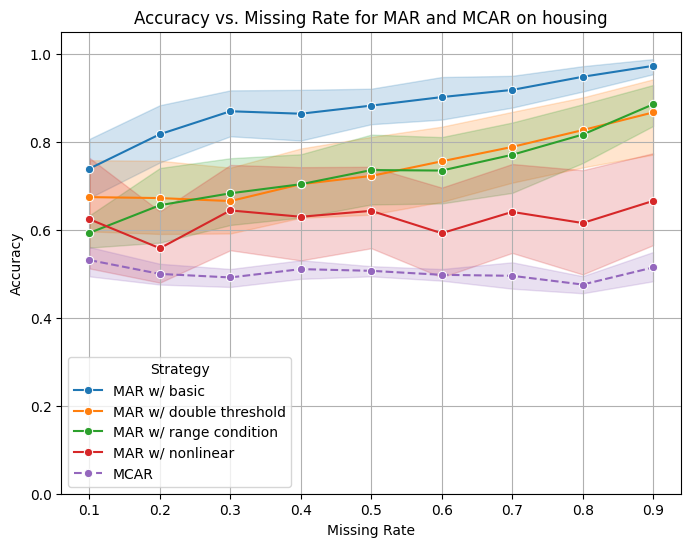

In [3]:
ds_name = 'housing'
results = run_exp(ds_name)
plot_missingness_clasification(results, ds_name)

450it [03:38,  2.06it/s]
/home/lotanamit5/missing_values_project/plots.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mar_results['legend_label'] = mar_results['strategy'].apply(lambda x: "MAR w/ "+x.replace('_', ' '))


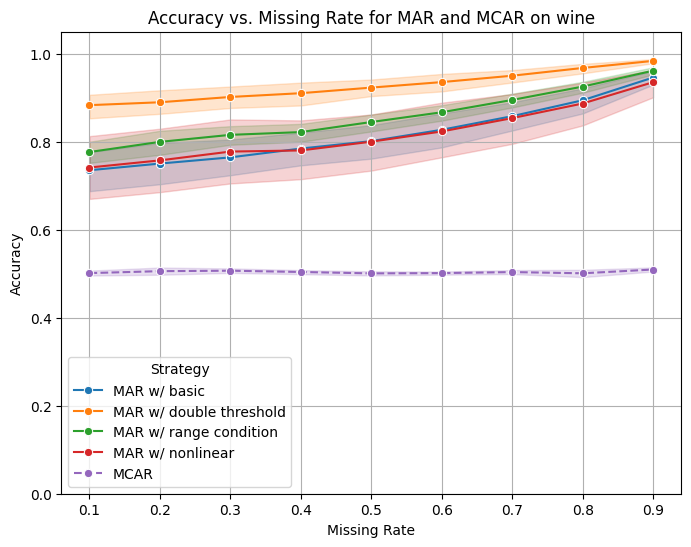

In [4]:
ds_name = 'wine'
results = run_exp(ds_name)
plot_missingness_clasification(results, ds_name)

450it [00:28, 15.69it/s]
/home/lotanamit5/missing_values_project/plots.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sns.lineplot(


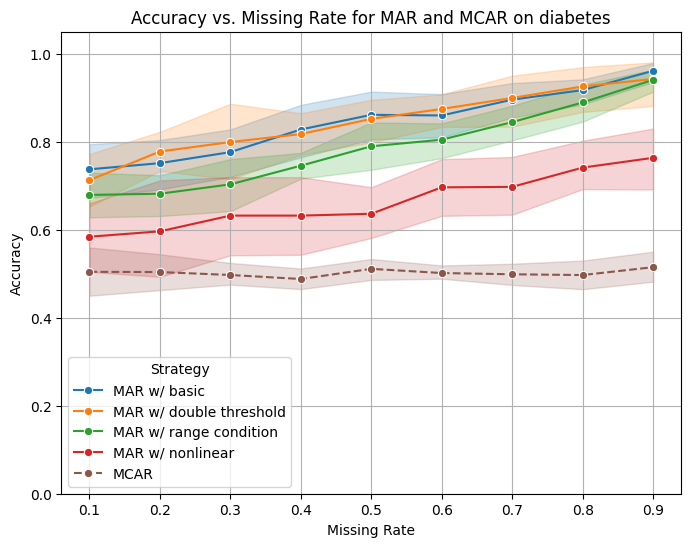

In [9]:
ds_name = 'diabetes'
results = run_exp(ds_name)
plot_missingness_clasification(results, ds_name)

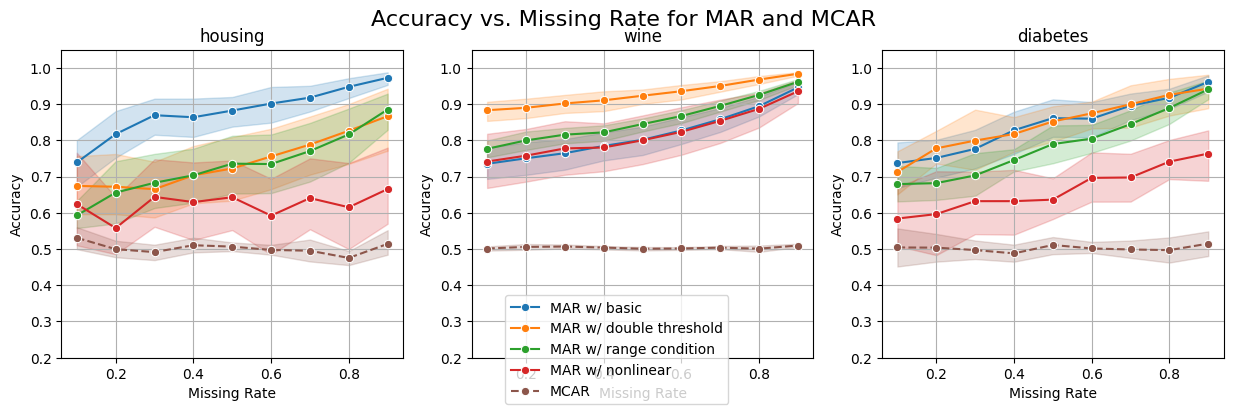

In [24]:
from plots import plot_all_missingness_classification
import warnings
warnings.filterwarnings("ignore")
plot_all_missingness_classification(['housing', 'wine', 'diabetes'])